<a href="https://colab.research.google.com/github/eletorres/MachineLearning/blob/main/ProyectoML_LTorres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <b> <center> Proyecto: calidad del aire en Curicó  </center> </b> </h1>

---

> ###### Estudiante: Luis Torres
> ###### Curso: Machine Learning

El siguiente trabajo, tiene por objetivo medir la calidad del aire en la ciudad de Curicó, Chile. Para este analisis se ha entregado un dataset con datos desde el año 2012 hasta la fecha, los cuales deben ser preprocesados para posteriormente aplicar un algoritmo de machine learning y evaluar el rendimiento de éste para el problema propuesto.

El flujo de trabajo utilizado ha sido el siguiente:

1.   Preprocesamiento de datos
2.   Entrenamiento del modelo considerando datos por hora.
3.  Entrenamiento del modelo considerando datos por día.
4.  Conclusiones

Además se incluye información relacionada a los sitios web utiles que permitieron resolver problemas en el preprocesamiento de datos y algunos tips utiles en el uso de pandas para el analisis de datos.



# Librerias python

In [1]:
import IPython.core.display
import matplotlib ## paquete necesario para poder hacer gráficas

def apply_styles(): ### especificamos los parámetros para los gráficos
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles() ### finalmente aplicamos el estilo

In [2]:
### éstos elementos configuran fuente tamaño color de la letra porcentaje etc.
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fbprophet import Prophet
%matplotlib inline
sns.set(style="ticks")
import warnings ## desactivan los mensajes para ciertos advertencias en las funciones
warnings.filterwarnings('ignore')

# Carga de datos, filtración y visualización

In [4]:
#Cargamos el Dataset desde cuenta personal de github
url="https://raw.githubusercontent.com/eletorres/MachineLearning/main/datos_120707_211130.csv"
nombrecolumnas=['FECHA (YYMMDD)','HORA (HHMM)','Registros validados','Registros preliminares','Registros no validados']
df = pd.read_csv(url,sep=';',usecols=nombrecolumnas)

#df.value.astype(int, copy=False);
df.head(3)

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
0,120707,100,NaN,NaN,NaN
1,120707,200,NaN,NaN,NaN
2,120707,300,NaN,NaN,NaN


In [5]:
df.shape

(82415, 5)

Una vez cargado el archivo CSV y visualizado correctamente en la tabla, se debe transformar los datos (DataFrame) de las columnas fechas y hora a una unidad de tiempo (DateTime) para posteriormente unir en una sola columna.


In [6]:
df['FECHA (YYMMDD)'].dtype

dtype('int64')

In [7]:
#print(df['FECHA (YYMMDD)'])

In [8]:
df[['HORA (HHMM)','Registros validados']].dtypes

HORA (HHMM)             int64
Registros validados    object
dtype: object

In [9]:
#print(df['HORA (HHMM)'])

In [10]:
from datetime import datetime

In [11]:
#Transformar int64 en datatime considerando año/mes/dia
df['FECHA (YYMMDD)']=pd.to_datetime(df['FECHA (YYMMDD)'],format="%y%m%d")

In [12]:
df.head(3)

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
0,2012-07-07,100,NaN,NaN,NaN
1,2012-07-07,200,NaN,NaN,NaN
2,2012-07-07,300,NaN,NaN,NaN


In [13]:
# Transformo los datos en hora, zfill permite completar con un cero los casos donde la hora aparece como 100
df['HORA (HHMM)']=pd.to_datetime(df['HORA (HHMM)'].astype(str).str.zfill(4),format="%H%M")


In [14]:
#La sentencia anterior genera datos considerando años, por lo que está linea dejara solo horas y minutos
df['HORA (HHMM)'] = df['HORA (HHMM)'].dt.strftime("%H:%M:%S")

In [15]:
df[['FECHA (YYMMDD)','HORA (HHMM)']].dtypes

FECHA (YYMMDD)    datetime64[ns]
HORA (HHMM)               object
dtype: object

In [16]:
df.head(3)

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
0,2012-07-07,01:00:00,NaN,NaN,NaN
1,2012-07-07,02:00:00,NaN,NaN,NaN
2,2012-07-07,03:00:00,NaN,NaN,NaN


Ahora se han transformado las 2 columnas. El paso siguiente es unir ambas para utilizarlas como variable en el eje de las X

In [17]:
df['DateTime'] = pd.to_datetime(df.pop('FECHA (YYMMDD)')) + pd.to_timedelta(df.pop('HORA (HHMM)'))

Ahora se debe escoger cuantas columnas se utilizarán para considerar la concentración de la calidad del aire. En primera instancia se evaluará solo considerar los registros validados

A continuación, se creará un nuevo set de datos con dos columnas

In [18]:
import numpy as np
df_new = pd.DataFrame(list(zip(df['DateTime'],df['Registros validados'])), columns = ['Tiempo','Contaminacion'])
print(df_new)

                   Tiempo Contaminacion
0     2012-07-07 01:00:00           NaN
1     2012-07-07 02:00:00           NaN
2     2012-07-07 03:00:00           NaN
3     2012-07-07 04:00:00           NaN
4     2012-07-07 05:00:00           NaN
...                   ...           ...
82410 2021-11-30 19:00:00           NaN
82411 2021-11-30 20:00:00           NaN
82412 2021-11-30 21:00:00           NaN
82413 2021-11-30 22:00:00           NaN
82414 2021-11-30 23:00:00           NaN

[82415 rows x 2 columns]


In [19]:
df_new['Contaminacion'] = df_new['Contaminacion'].str.replace(",", ".").astype(float)  #Los datos vienen separados por coma, por lo que se cambiará a punts


In [20]:
df_new[['Tiempo','Contaminacion']].dtypes

Tiempo           datetime64[ns]
Contaminacion           float64
dtype: object

df_new representa el nuevo Dataframe considerando la serie de tiempo y los valores de contaminación del aire a partir de los registros validados. Desde la linea anterior se puede observar que existen muchos datos con valor NaN, por lo que se debe tomar una decisión de que hacer con estos.

Lo primero que se hará será utilizar dropna para eliminar y ver cuanta información se pierde.

In [21]:
df_new.dropna()

,Tiempo,Contaminacion
5687,2013-03-01 00:00:00,6.0
5688,2013-03-01 01:00:00,3.0
5689,2013-03-01 02:00:00,4.0
5690,2013-03-01 03:00:00,4.0
5691,2013-03-01 04:00:00,2.0
...,...,...
65610,2019-12-31 19:00:00,21.0
65611,2019-12-31 20:00:00,28.0
65612,2019-12-31 21:00:00,30.0
65613,2019-12-31 22:00:00,33.0


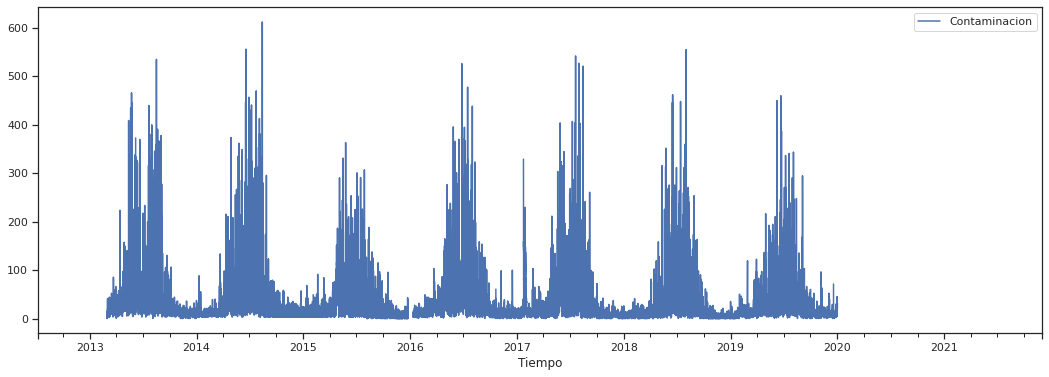

In [22]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df_new.plot(x="Tiempo", y="Contaminacion", ax=ax)
plt.legend(loc='upper right')
plt.savefig('intro-visualization.png'); ## recuerda crear la carpeta 'images'


In [23]:
max_date = df_new.Tiempo.max() ## accedemos al periodo y obtenemos el máximo valor de la fecha
min_date = df_new.Tiempo.min() ## acá hacemos lo análogo pero con el mínimo

num_of_actual_points = df_new.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Date range: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))

Date range: 07.07.2012 - 30.11.2021
Number of data points: 82415 of expected 113


Al eliminar directamente los valores NaN de la columna registros validos, el dataset sufre una considerable perdida de información, de casi 30 mil registros, que se traducen a meses de observaciones no validadas. A partir de esto, es que se toma la decisión que lo más razonable es realizar un preprocesamiento en los datos.

A continuación se implementará una imputación en los datos considerando la mediana, si se quisiera considerar el promedio se debe cambiar median() por mean(). En ambos casos se ve una linea recta que ha sido generada por el cambio de los datos con Nan, para el caso del promedio es de 26.57, mientras que para el promedio es de 14.18

In [24]:
df_new['Contaminacion'] = df_new['Contaminacion'].fillna((df_new['Contaminacion'].median()))

In [25]:
print(df_new['Contaminacion'])

0        14.18
1        14.18
2        14.18
3        14.18
4        14.18
         ...  
82410    14.18
82411    14.18
82412    14.18
82413    14.18
82414    14.18
Name: Contaminacion, Length: 82415, dtype: float64


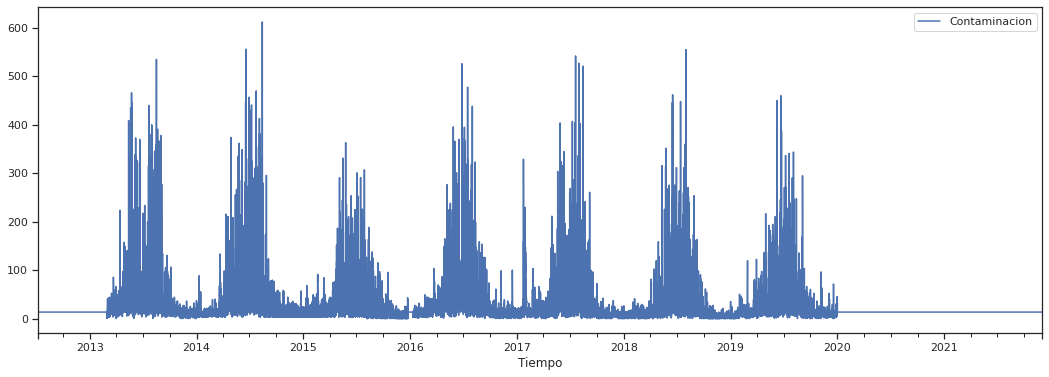

In [26]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df_new.plot(x="Tiempo", y="Contaminacion", ax=ax)
plt.legend(loc='upper right')
plt.savefig('intro-visualization.png'); ## recuerda crear la carpeta 'images'

Desde la imputación de datos se puede ver que está estrategia solo generará una recta al cambiar los valores Nan por el promedio. Por lo que se hará una combinación de datos entre los registros validados y los preliminares, considerando que mostrarán más variación en el tiempo, y que estará más acorde al problema considerando que en los graficos previos se ve que hay momentos del año donde la concentración es muy alta y momentos del año donde es muy baja, por lo que si se considerará el promedio hecho por la imputación no estaría reflejando una variación.

In [27]:
df['Registros validados'] = df['Registros validados'].str.replace(",", ".").astype(float)
df['Registros preliminares'] = df['Registros preliminares'].str.replace(",", ".").astype(float)
df=df.replace(np.nan,0)  #reemplazo del nan por 0 para poder sumar las dos columnas

In [28]:
df['Registros'] = df['Registros validados'] + df['Registros preliminares']
#print(df['Registros'][82386])  #Comprobación de suma 

In [29]:
df_new2 = pd.DataFrame(list(zip(df['DateTime'],df['Registros'])), columns = ['Tiempo','Contaminacion'])

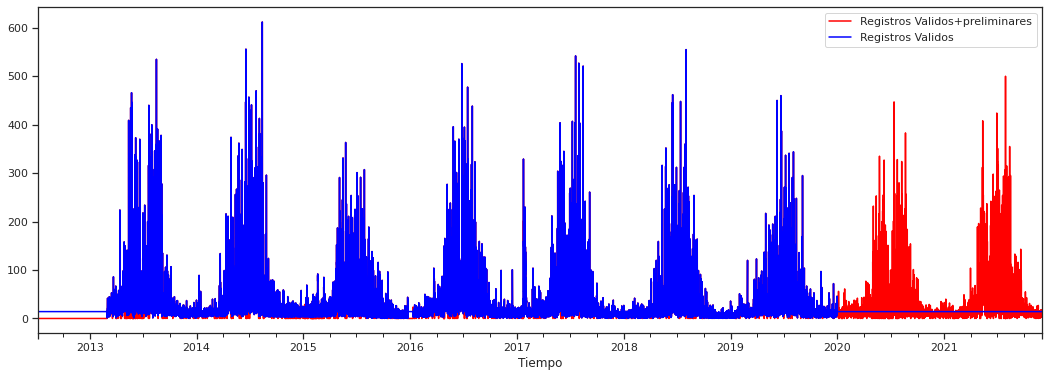

In [30]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df_new2.plot(x="Tiempo", y="Contaminacion", ax=ax, color='red')
df_new.plot(x="Tiempo", y="Contaminacion", ax=ax, color='blue')
plt.legend(['Registros Validos+preliminares','Registros Validos'])
plt.savefig('intro-visualization.png'); 

In [31]:
# Exportación de Dataframe filtrado a un csv

df_new2.to_csv('proyectoML.csv', index=False)

A partir de los registros validos y los preliminares se puede observar del grafico que entre el año 2012 e inicio del 2013 es dificil hacer una predicción, ya que no existen valores y el promedio no es representativo, por otra parte, los datos obtenidos de los registros preliminares sumados a los validados, presentan dinamicas muy similares a los valores validados, por lo que es un buen indicio que la estrategia escogida puede presentar buenos resultados.



In [32]:
#Del paquete statmodel se obtiene un modelo para hacer descomposición de estacionalidad 
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # 12 months seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df_new2.set_index("Tiempo").Contaminacion.interpolate("linear"),
    freq=decompfreq,
    model=model)

In [33]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

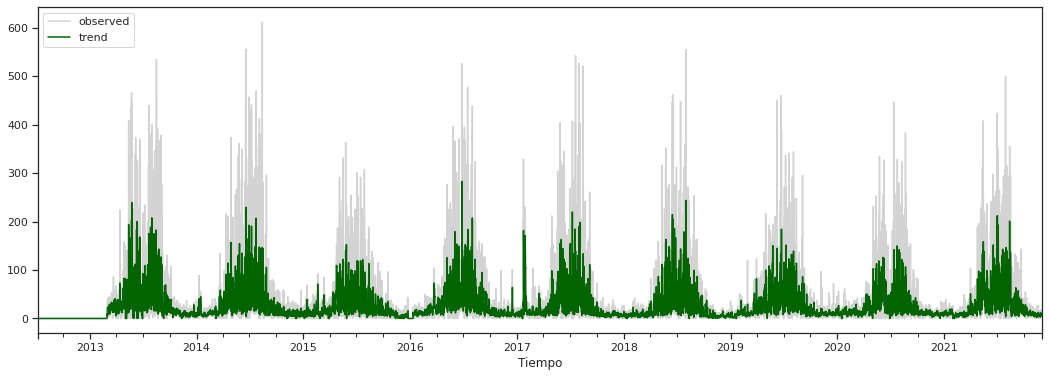

In [34]:
## ahora se realizan los gráficos uno a uno comenzando por la tendencia
fig, ax = plt.subplots(figsize=(18,6))
df_new2.plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend", color="darkgreen") ## si se fijan aquí se está utilizando el objeto 'trend'
plt.legend(loc='upper left')

plt.savefig('intro-trend.png');

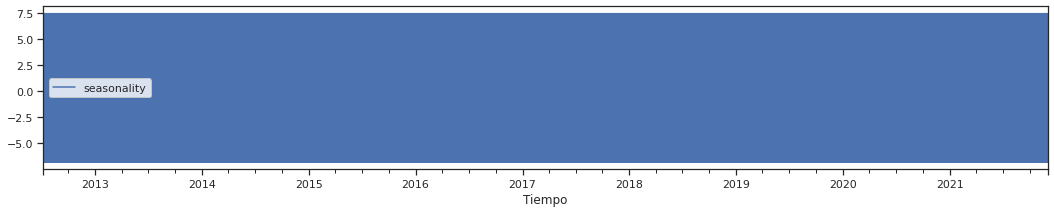

In [35]:
## ahora es el turno de graficar la estacionalidad
fig, ax = plt.subplots(figsize=(18,3)) ## aquí indicamos las proporciones del gráfico, que en este caso se hace un poco más delgados
seasonal.plot(ax=ax, label="seasonality") # aquí se usa el objeto seasonal que se obtuvo los pasos anteriores
plt.legend(loc='bottom left')

plt.savefig('intro-seasonality.png');

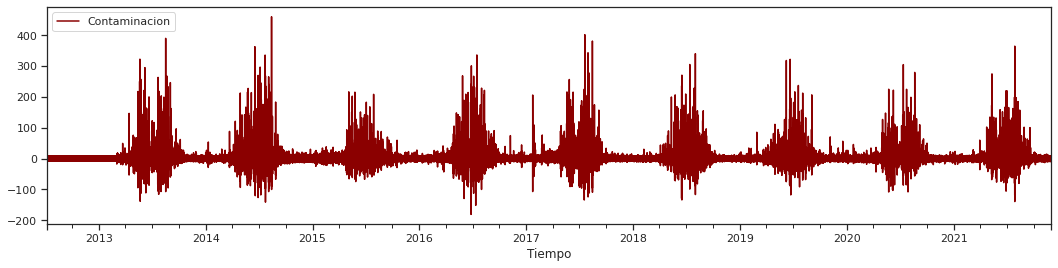

In [36]:
## finalmente gráfica vamos los elementos residuales
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality", color="darkred") ## Y se utiliza el objeto residual que se obtuvo en la descomposición de la serie
plt.legend(loc='upper left')

plt.savefig('intro-residual.png');

# Entrenamiento del modelo considerando fechas con horas

Separación de los datos de entrenamiento

Para hacer los analisis, ahora se debe separar los datos de entrenamiento de los datos de validación, considerando que desde el 2020 los datos son preliminares, se consideraran los datos hasta 2019, dejando parte de los datos validados y preliminares para hacer las pruebas del modelo de predicción

In [37]:
# Separación entre datos de entrenamiento y de validación, se debe considerar de forma continua al ser series de tiempo
train_range = df_new2[df_new2.Tiempo < '2019-01-01'].index
test_range = df_new2[(df_new2.Tiempo >= '2019-01-02')].index

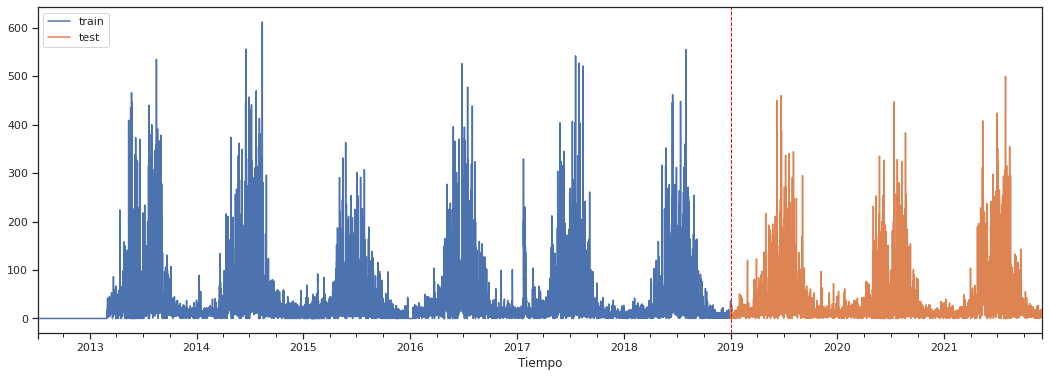

In [38]:
fig, ax = plt.subplots(figsize=(18,6))
df_new2.loc[train_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="train")
df_new2.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df_new2.loc[test_range].Tiempo.values[0])), c='red', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('prophet-split.png'); ## recuerda crear la carpeta images si trabajas con Google Colab

##Prophet


In [39]:
df_prophet_train = df_new2.loc[train_range][["Tiempo", "Contaminacion"]]
df_prophet_train.columns = ["ds", "y"]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    #changepoints=list(changepoints.keys()),
    mcmc_samples=12,
    growth='linear',
    interval_width=0.9)

In [40]:
model.fit(df_prophet_train);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Predicción


In [41]:
df_prophet_test = df_new2.loc[test_range][["Tiempo", "Contaminacion"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df_new2.loc[test_range].Contaminacion.values

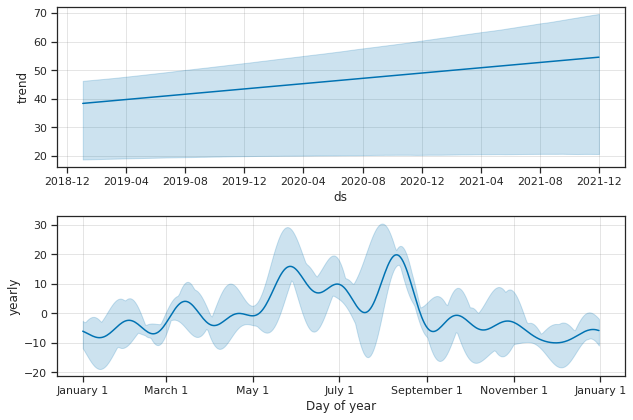

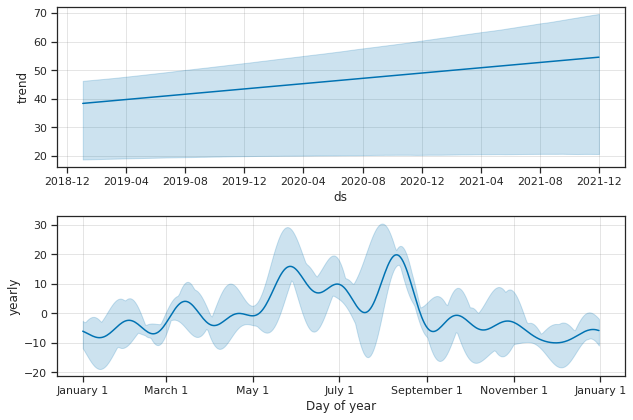

In [42]:
model.plot_components(forecast)

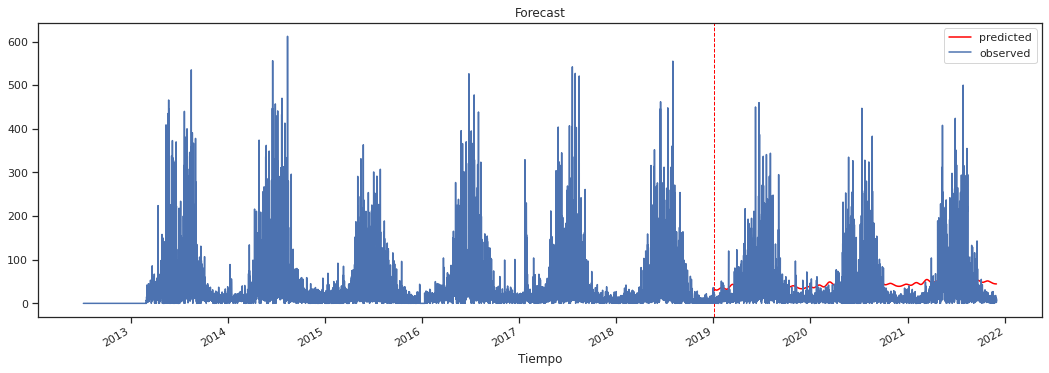

In [43]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_new2.loc[test_range].Tiempo.values), yhat_test,
        color="red", label="predicted")

plt.axvline(pd.to_datetime(str(df_new2.loc[test_range].Tiempo.values[0])), c='red', ls='--', lw=1)
df_new2.plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Forecast')

plt.savefig('prophet-forecast-testrange.png')
plt.show();

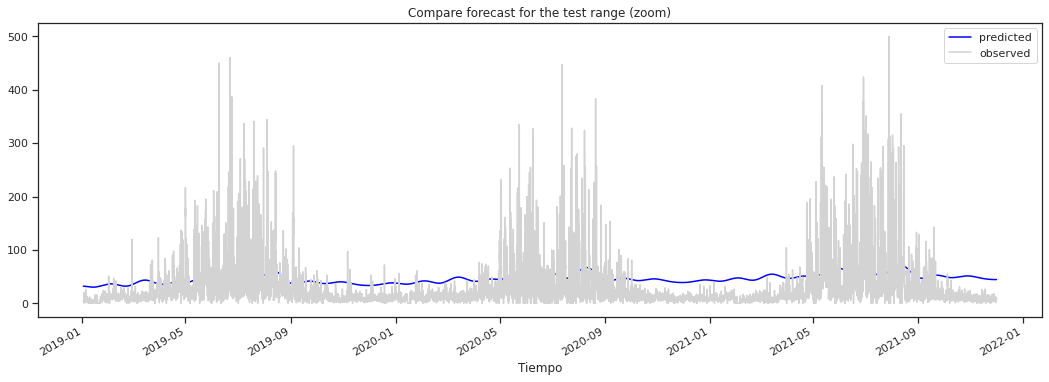

In [44]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_new2.loc[test_range].Tiempo.values), yhat_test,
        color="blue", label="predicted")

df_new2.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed",color="lightgrey")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


plt.savefig('prophet-forecast-testrange-zoom.png')
plt.show();

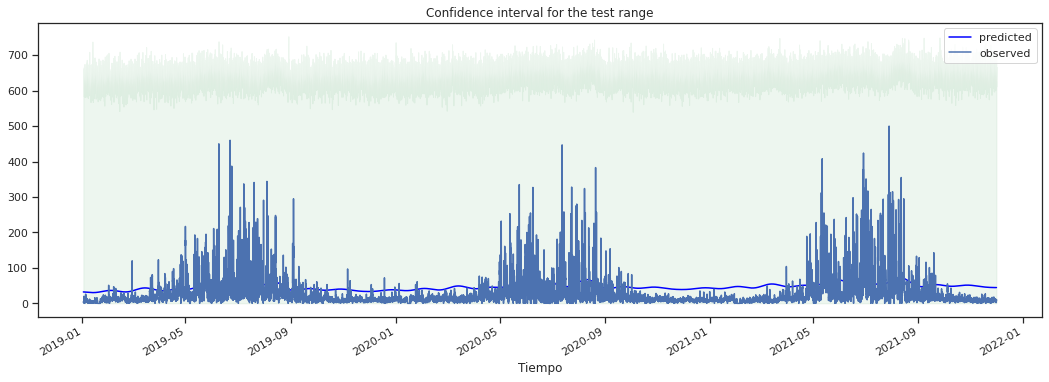

In [45]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_new2.loc[test_range].Tiempo.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    #forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

df_new2.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.savefig('prophet-forecast-testrange-confidence-interval.png')
plt.show();

## Evaluacion de Forecast

In [46]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [47]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)
MAPE = mean_absolute_percentage_error(y_test, yhat_test)*100

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))
print("MAPE (test): {:0.0f} %".format(MAPE))


MAE (test): 32
MSE (test): 1498
R2  (test): -0.326
U   (test): 0.019648
MAPE (test): 411064052425819008 %


# Entrenamiento del modelo considerando fechas por dia

In [48]:
# groupby permite agrupar rapidamente el datetime por dias utilizando freq como D,
# si se quiere agrupar por mes se debe poner M

df_day=df_new2.groupby(pd.Grouper(key='Tiempo',freq='D')).mean().reset_index()   

# se debe agregar .reset_index() para no perder una columna del dataset por la transformación,
# más información en https://towardsdatascience.com/all-pandas-groupby-you-should-know-for-grouping-data-and-performing-operations-2a8ec1327b5

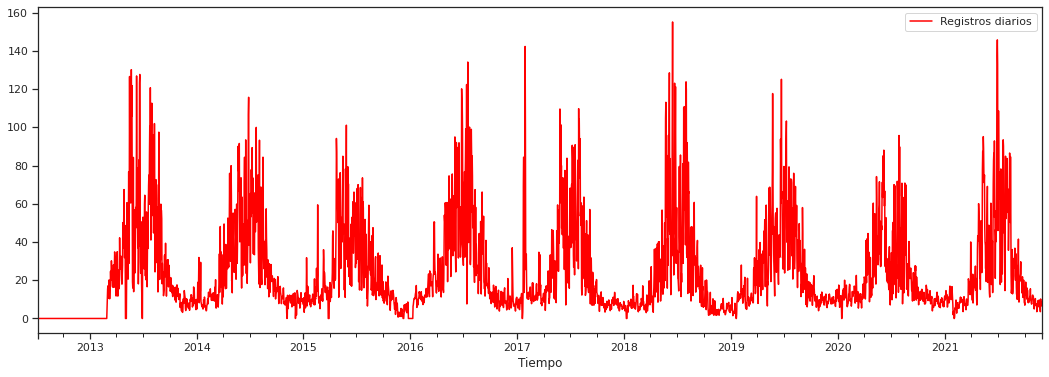

In [49]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df_day.plot(x="Tiempo", y="Contaminacion", ax=ax, color='red')
plt.legend(['Registros diarios'])
plt.savefig('intro-visualization.png'); 

In [50]:
#Del paquete statmodel se obtiene un modelo para hacer descomposición de estacionalidad 
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # 12 months seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df_day.set_index("Tiempo").Contaminacion.interpolate("linear"),
    freq=decompfreq,
    model=model)

In [51]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

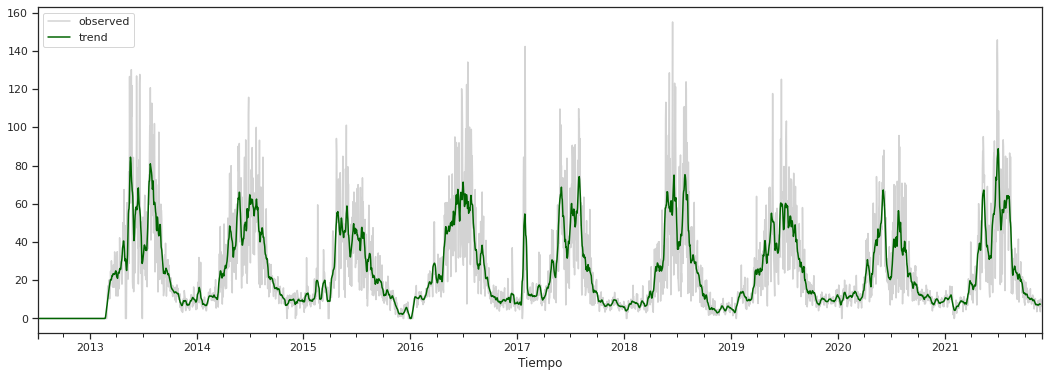

In [52]:
## ahora se realizan los gráficos uno a uno comenzando por la tendencia
fig, ax = plt.subplots(figsize=(18,6))
df_day.plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend", color="darkgreen") ## si se fijan aquí se está utilizando el objeto 'trend'
plt.legend(loc='upper left')

plt.savefig('intr-trend.png');

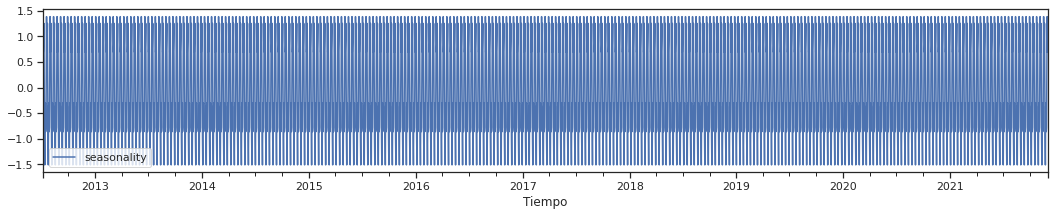

In [53]:
## ahora es el turno de graficar la estacionalidad
fig, ax = plt.subplots(figsize=(18,3)) ## aquí indicamos las proporciones del gráfico, que en este caso se hace un poco más delgados
seasonal.plot(ax=ax, label="seasonality") # aquí se usa el objeto seasonal que se obtuvo los pasos anteriores
plt.legend(loc='bottom left')

plt.savefig('intro-seasonality.png');

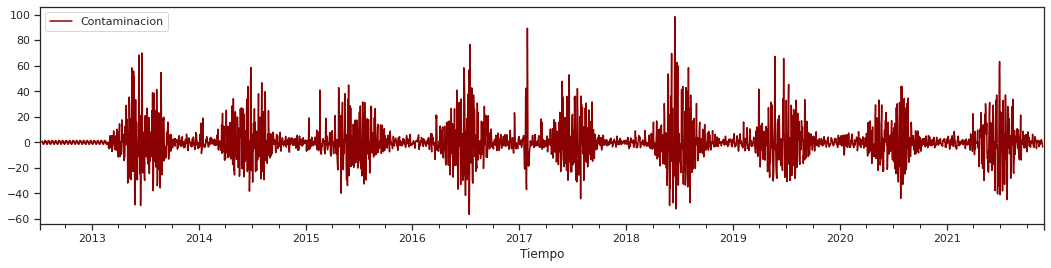

In [54]:
## finalmente gráfica vamos los elementos residuales
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality", color="darkred") ## Y se utiliza el objeto residual que se obtuvo en la descomposición de la serie
plt.legend(loc='upper left')

plt.savefig('intro-residual.png');

In [55]:
# Separación entre datos de entrenamiento y de validación, se debe considerar de forma continua al ser series de tiempo
train_range = df_day[df_day.Tiempo < '2019-01-01'].index
test_range = df_day[(df_day.Tiempo >= '2019-01-02')].index

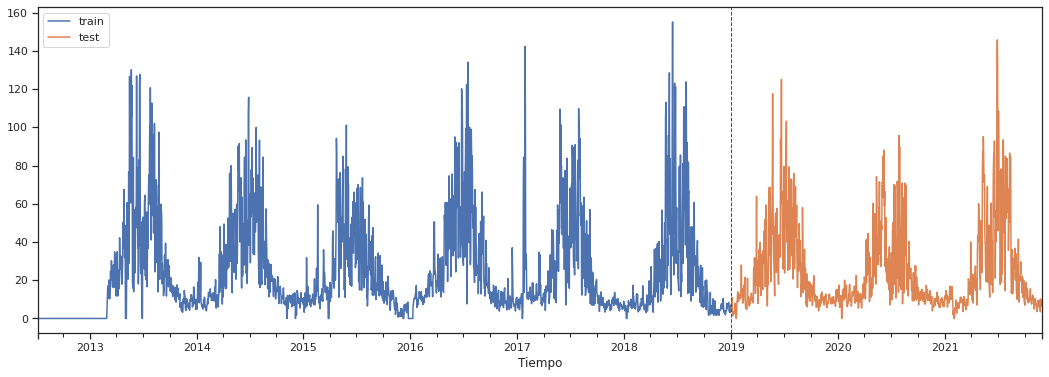

In [56]:
fig, ax = plt.subplots(figsize=(18,6))
df_day.loc[train_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="train")
df_day.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df_day.loc[test_range].Tiempo.values[0])), c='red', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('prophet-split.png'); ## recuerda crear la carpeta images si trabajas con Google Colab

## Prophet, analisis diario




In [57]:
df_prophet_train = df_day.loc[train_range][["Tiempo", "Contaminacion"]]
df_prophet_train.columns = ["ds", "y"]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=True,
    #changepoints=list(changepoints.keys()),
    mcmc_samples=12,
    growth='linear',
    interval_width=0.9)

In [58]:
model.fit(df_prophet_train);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [59]:
df_prophet_test = df_day.loc[test_range][["Tiempo", "Contaminacion"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df_day.loc[test_range].Contaminacion.values

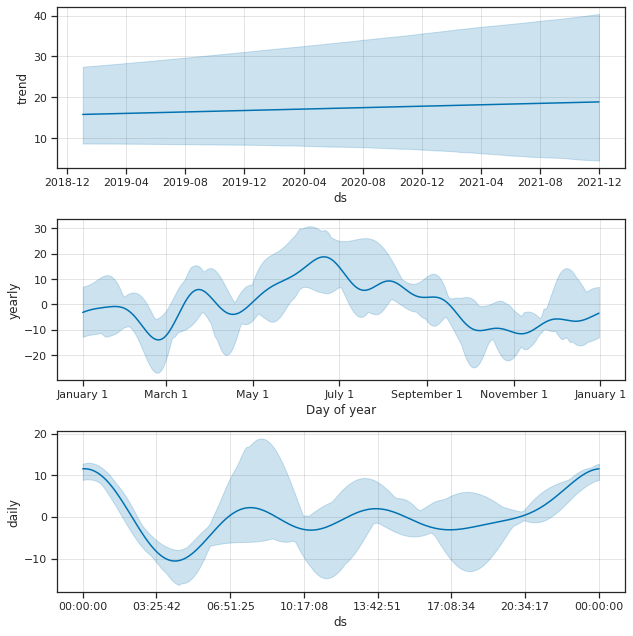

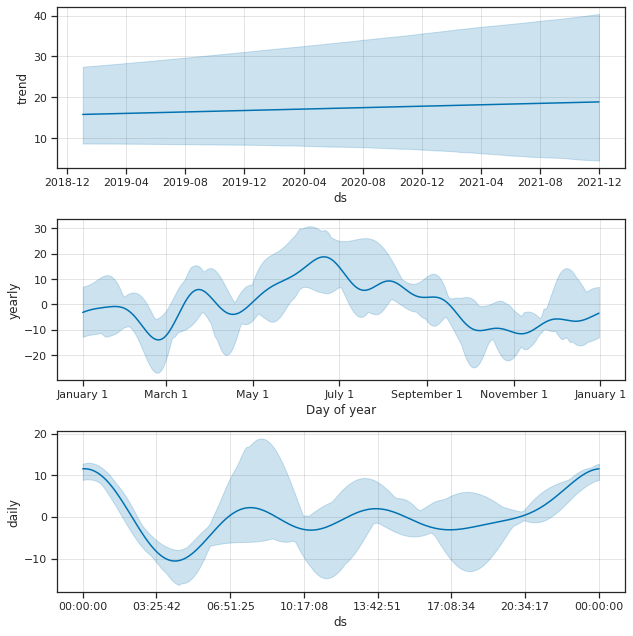

In [60]:
model.plot_components(forecast)

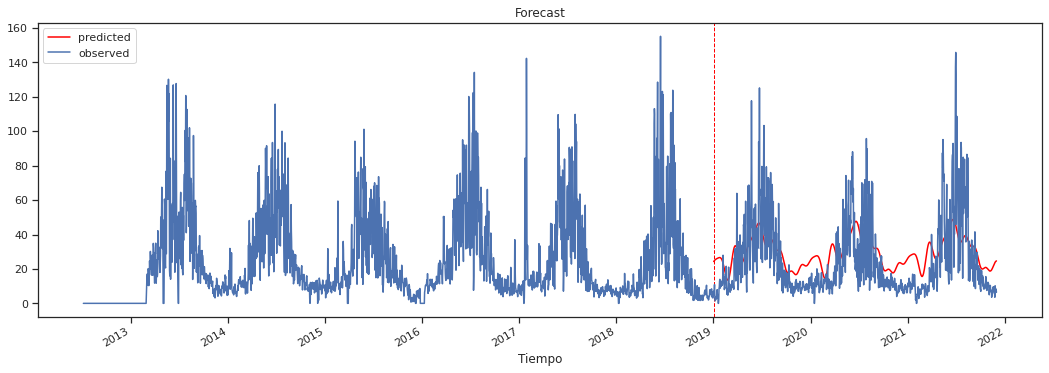

In [61]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_day.loc[test_range].Tiempo.values), yhat_test,
        color="red", label="predicted")

plt.axvline(pd.to_datetime(str(df_day.loc[test_range].Tiempo.values[0])), c='red', ls='--', lw=1)
df_day.plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Forecast')

plt.savefig('prophet-forecast-testrange.png')
plt.show();

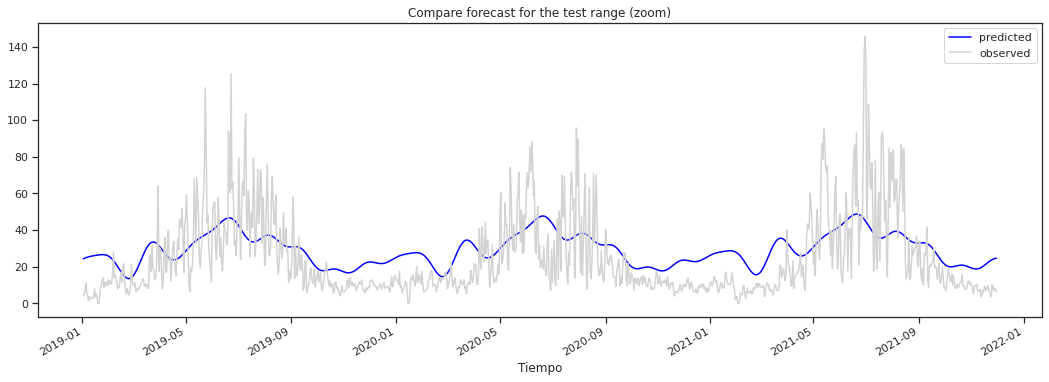

In [62]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_day.loc[test_range].Tiempo.values), yhat_test,
        color="blue", label="predicted")

df_day.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed",color="lightgrey")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


plt.savefig('prophet-forecast-testrange-zoom.png')
plt.show();

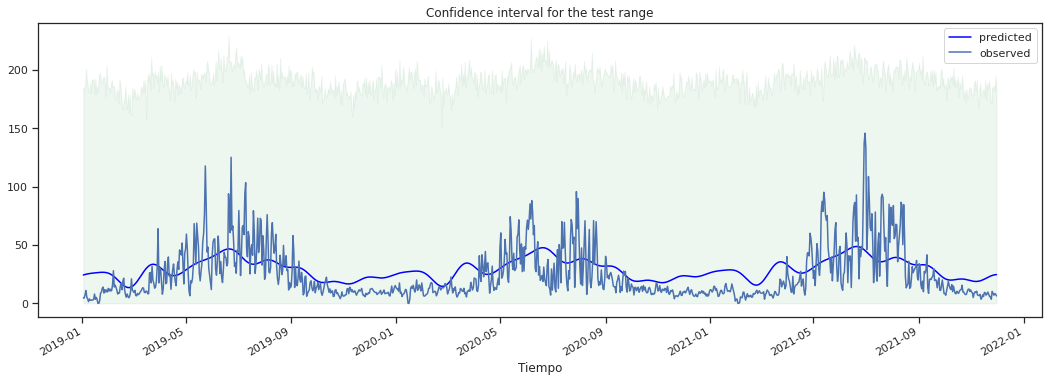

In [63]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_day.loc[test_range].Tiempo.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    #forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

df_day.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.savefig('prophet-forecast-testrange-confidence-interval.png')
plt.show();

In [64]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [65]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)
MAPE = mean_absolute_percentage_error(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))
print("MAPE (test): {:0.0f} %".format(MAPE))

MAE (test): 15
MSE (test): 337
R2  (test): 0.294
U   (test): 0.018552
MAPE (test): 681829160477098 %


# ¿Qué ocurre si se eliminan los ceros del dataset antes de promediar las horas del mismo día?, ¿mejorará el modelo?

Lo primero que se realizará será trabajar sobre el dataframe que contiene las fechas ya modificadas y donde la segunda columna está compuesta por registros validos y preliminares, el paso siguiente es eliminar todos los datos que son cero para ver la influencia directa en la predicción del modelo.

In [66]:
df_new3 = df_new2[(df_new2[['Contaminacion']] != 0).all(axis=1)]
print(df_new2)

                   Tiempo  Contaminacion
0     2012-07-07 01:00:00            0.0
1     2012-07-07 02:00:00            0.0
2     2012-07-07 03:00:00            0.0
3     2012-07-07 04:00:00            0.0
4     2012-07-07 05:00:00            0.0
...                   ...            ...
82410 2021-11-30 19:00:00            3.0
82411 2021-11-30 20:00:00            7.0
82412 2021-11-30 21:00:00            7.0
82413 2021-11-30 22:00:00           11.0
82414 2021-11-30 23:00:00            7.0

[82415 rows x 2 columns]


In [67]:
df_new3=df_new3.groupby(pd.Grouper(key='Tiempo',freq='D')).mean().reset_index() 
print(df_new3)

         Tiempo  Contaminacion
0    2013-03-01       5.875000
1    2013-03-02      10.250000
2    2013-03-03      15.333333
3    2013-03-04      17.041667
4    2013-03-05      17.125000
...         ...            ...
3192 2021-11-26       8.750000
3193 2021-11-27       7.000000
3194 2021-11-28       8.333333
3195 2021-11-29       7.875000
3196 2021-11-30       6.375000

[3197 rows x 2 columns]


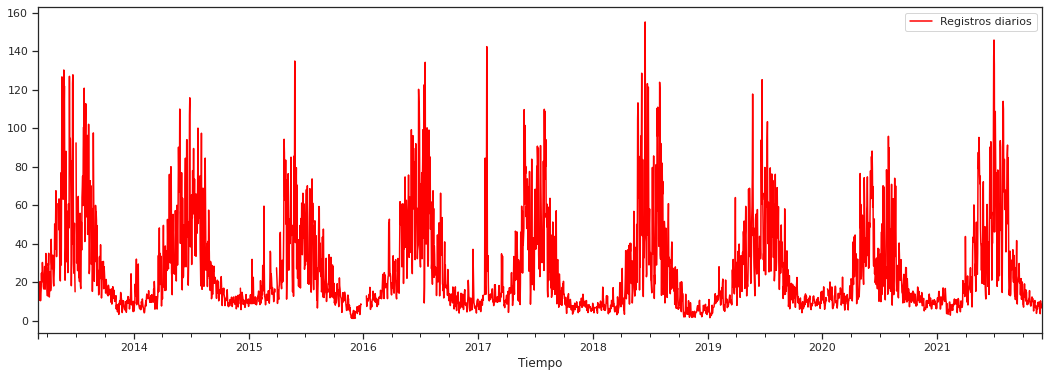

In [68]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df_new3.plot(x="Tiempo", y="Contaminacion", ax=ax, color='red')
plt.legend(['Registros diarios'])
plt.savefig('in-visualization.png'); 

In [69]:
decompfreq = 12  # 12 months seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df_new3.set_index("Tiempo").Contaminacion.interpolate("linear"),
    freq=decompfreq,
    model=model)

In [70]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

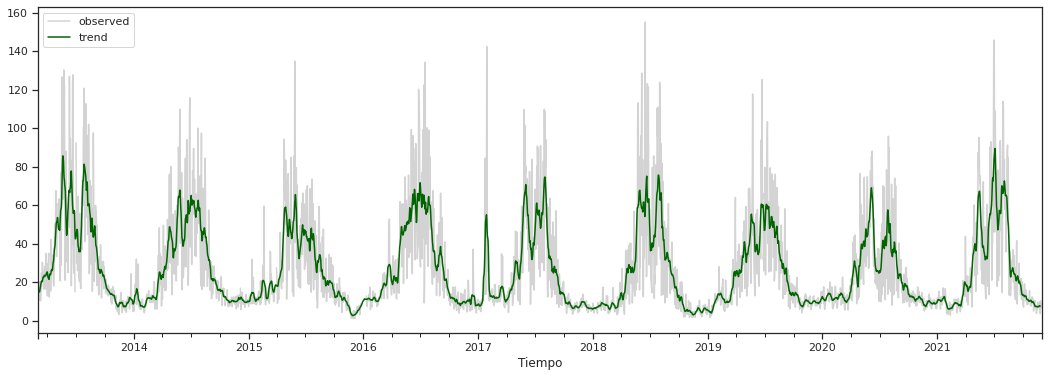

In [71]:
## ahora se realizan los gráficos uno a uno comenzando por la tendencia
fig, ax = plt.subplots(figsize=(18,6))
df_new3.plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend", color="darkgreen") ## si se fijan aquí se está utilizando el objeto 'trend'
plt.legend(loc='upper left')

plt.savefig('intr-trend.png');

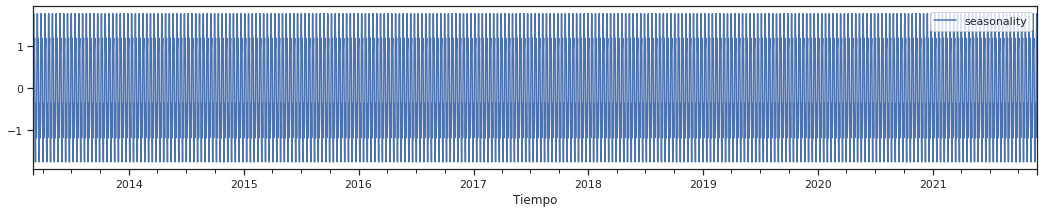

In [72]:
## ahora es el turno de graficar la estacionalidad
fig, ax = plt.subplots(figsize=(18,3)) ## aquí indicamos las proporciones del gráfico, que en este caso se hace un poco más delgados
seasonal.plot(ax=ax, label="seasonality") # aquí se usa el objeto seasonal que se obtuvo los pasos anteriores
plt.legend(loc='bottom left')

plt.savefig('intro-seasonality.png');

In [73]:
# Separación entre datos de entrenamiento y de validación, se debe considerar de forma continua al ser series de tiempo
train_range = df_new3[df_new3.Tiempo < '2019-01-01'].index
test_range = df_new3[(df_new3.Tiempo >= '2019-01-02')].index

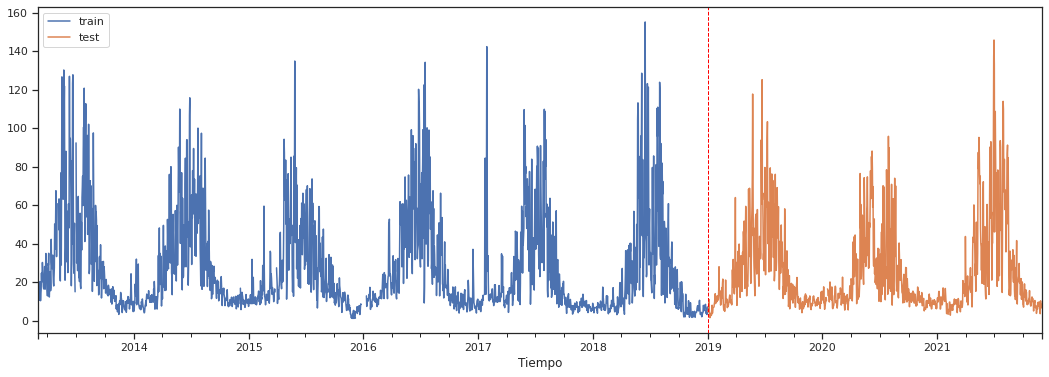

In [74]:
fig, ax = plt.subplots(figsize=(18,6))
df_new3.loc[train_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="train")
df_new3.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df_new3.loc[test_range].Tiempo.values[0])), c='red', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('prophet-split.png'); ## recuerda crear la carpeta images si trabajas con Google Colab

In [75]:
df_prophet_train = df_new3.loc[train_range][["Tiempo", "Contaminacion"]]
df_prophet_train.columns = ["ds", "y"]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=True,
    #changepoints=list(changepoints.keys()),
    mcmc_samples=12,
    growth='linear',
    interval_width=0.9)

In [76]:
model.fit(df_prophet_train);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [77]:
df_prophet_test = df_new3.loc[test_range][["Tiempo", "Contaminacion"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df_day.loc[test_range].Contaminacion.values

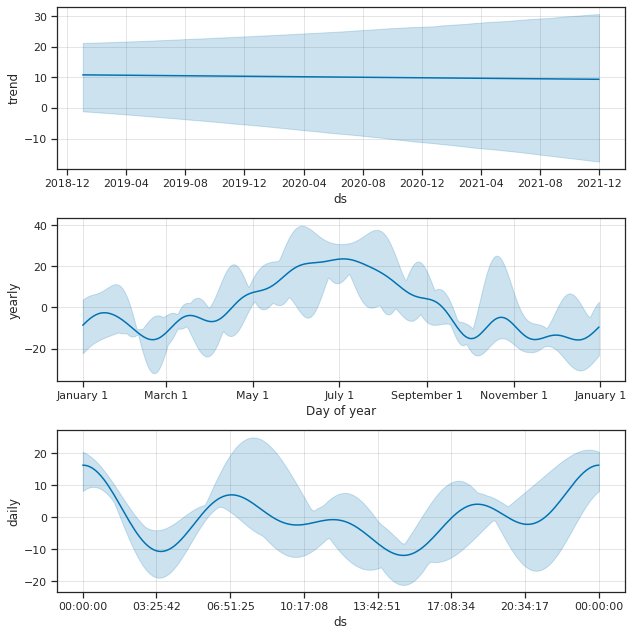

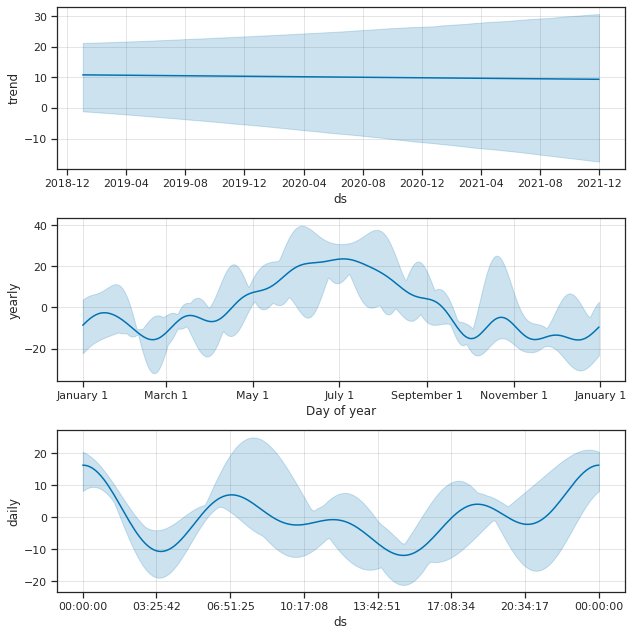

In [78]:
model.plot_components(forecast)

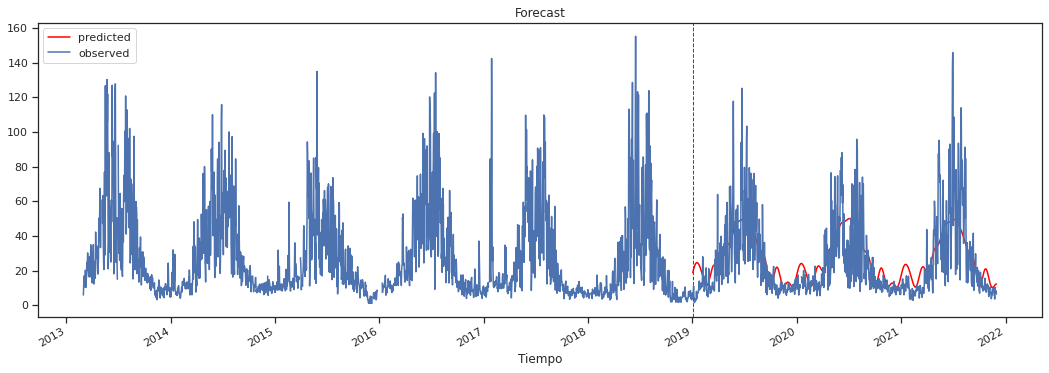

In [79]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_new3.loc[test_range].Tiempo.values), yhat_test,
        color="red", label="predicted")

plt.axvline(pd.to_datetime(str(df_new3.loc[test_range].Tiempo.values[0])), c='red', ls='--', lw=1)
df_new3.plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Forecast')

plt.savefig('prophet-forecast-testrange.png')
plt.show();

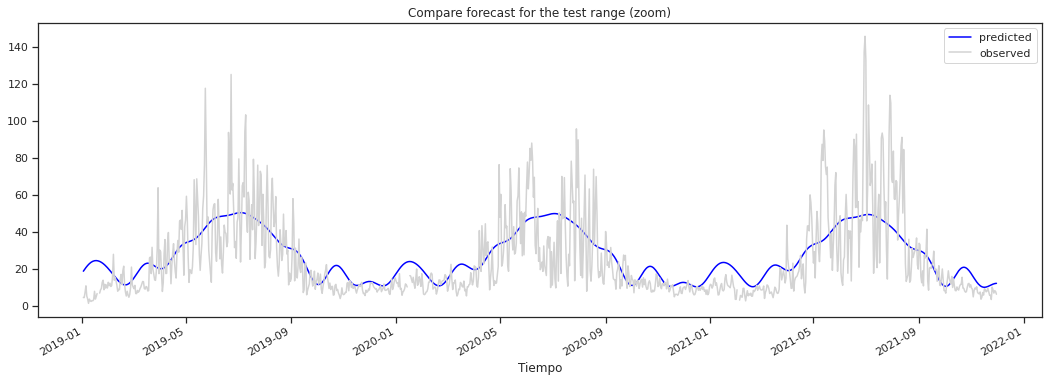

In [80]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_new3.loc[test_range].Tiempo.values), yhat_test,
        color="blue", label="predicted")

df_new3.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed",color="lightgrey")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


plt.savefig('prophet-forecast-testrange-zoom.png')
plt.show();

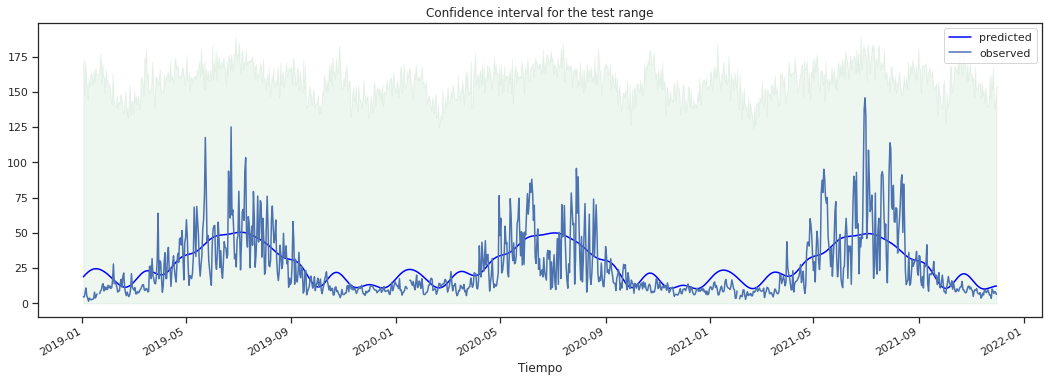

In [81]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_new3.loc[test_range].Tiempo.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    #forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

df_new3.loc[test_range].plot(x="Tiempo", y="Contaminacion", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.savefig('prophet-forecast-testrange-confidence-interval.png')
plt.show();

In [82]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)
MAPE = mean_absolute_percentage_error(y_test, yhat_test)*100

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))
print("MAPE (test): {:0.0f} %".format(MAPE))


MAE (test): 23
MSE (test): 881
R2  (test): -0.762
U   (test): 0.030883
MAPE (test): 55907028177527496 %


# Resultados de los test

|Test | MAE | MSE | R2 | U | MAPE |
| -- | -- | -- |-- | -- | -- |
|Entrenamiento Hora| 36 |1739| -0.339 | 0.019470 |454437056206282880 % |
|Entrenamiento dia| 15 | 337 | 0.594 | 0.018552| 457284633471663 %|
|Entrenamiento dia(sin ceros)| 21 | 695 | -0.391 | 0.029172 | 68422879428531384 % |
 


La tabla representa los resultados obtenidos  en los tres test. MAE, MSE y MAPE permiten calcular errores, cada uno tiene su forma distinta de calcular pero entre menor sea el número, mejor es el modelo, por lo tanto se puede observar que entrenar el modelo con datos por día es la mejor opción observando todas las metricas de la tabla. Por otra parte, $R^2$ entre más cercano a 1 será mejor el modelo, de esta forma, se puede evidenciar que el entrenamiento por día siguie siendo la mejor opción. 

# Conclusiones


A partir de este trabajo se puede concluir lo siguiente:


*   El dataset entregado necesitaba un alto preprocesamiento de información, esto debido a que eran medidas de un caso real, lo cual permitió aprender a trabajar con datos horarios para un análisis de tiempo.
*   En este trabajo, la toma de decisiones de como considerar los datos es parte fundamental antes de aplicar alguna estrategia de aprendizaje automático. Para llegar a esta conclusión se hicieron 3 estudios distintos respecto a la mejor estrategia, mostrando que para el análisis de tiempo, una buena idea es agrupar los datetime por día, lo cual fue el segundo análisis realizado en el presente trabajo.

* Del estudio diario de contaminación se a mostrado desde la metrica $R^2$ que mejora considerablemente a estudiar por hora, pasando de un valor negativo a un $R^2$ cercano a 0.5 lo cual indica que el modelo prophet mejora considerablemente pero no es una buena estrategia para este tipo de problema.

* Eliminar los ceros de la fechas parecia una buena estrategia, pero considerando que las series de tiempo deben ser continuas, está eliminación ha generado discontinuidades que han terminado generando un modelo aun peor (caso 3 estudiado).

Finalmente, el estudio realizado ha entregado muchas herramientas para poder abordar un problema real con un dataset que debia ser trabajado. Como trabajo futuro, seria interesante resolver este problema con otra técnica de aprendizaje automatico, por ejemplo por LSTM.



# Website utiles

Transformar de Dataset a Datetime
https://www.dataindependent.com/pandas/pandas-to-datetime/

Corregir hora en datos 
https://stackoverflow.com/questions/23836277/add-leading-zeros-to-strings-in-pandas-dataframe

Pandas
https://joserzapata.github.io/courses/python-ciencia-datos/pandas/

Agrupar datetime en pandas
https://kanoki.org/2020/05/26/dataframe-groupby-date-and-time/

Problema en agrupar dataset (perdida de una columna, solución aqui)
https://towardsdatascience.com/all-pandas-groupby-you-should-know-for-grouping-data-and-performing-operations-2a8ec1327b5